# Homework 2 - balancing, transformations, and dimensionality reduction (deadline 21. 12. 2025, 23:59)

In short, the main task is to play with balancing, binning, transformations, and dimensionality reduction to obtain the best results for the binary classification task.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment on all your steps. Use Markdown cells and visualizations. Comments are evaluated for 2 points of the total, together with the final presentation of the solution. However, it is not desirable to write novels! 
* This task is timewise and computationally intensive. Do not leave it to the last minute.
* Most steps contain the number of features that should be treated. You can preprocess more features. However, it does not mean the teacher will give you more points. Focus on quality, not quantity.
* Hand in a notebook that has already been run (i.e., do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0). Split the dataset into a train, validation, and test set and **use these parts correctly (!)** in the following steps.
  1. Choose at least one classification algorithm whose performance is to be improved in the following steps.
  1. Use at least two binning methods (on features of your choice, with your choice of parameters) and comment on their effects on classification performance. _I.e., one kind of classifier trained for each binning and a comparison of the effect of binning methods against each other._ _(4 points, depends on creativity)_ 
  1. Use at least two data balancing techniques on the correct part of the dataset and comment on its effects on classification performance. Focus on the comparison of methods between each other. _I.e., one type of classifier trained for each balancing and a comparison of the effect of balancing methods against each other._ **Just copied code from tutorial four will not be accepted.** _(6 points, depends on creativity)_
  1. Transform the features appropriately and prepare new ones (i.e., feature engineering) - focus on the increase in the model's performance (possibly in combination with further steps). _(5 points, depends on creativity)_ 
  1. Try to find some suitable subset of features - use at least two feature selection methods. Evaluate your choice on the validation set and discuss the influence. Do not use PCA (principal component analysis) in this step. Manual selection will not be accepted. _(4 points, depends on creativity)_
  1. Use PCA to reduce the dimensionality. Discuss the influence of the number of principal components. _(4 points)_
  1. Try to find the best combination of the previous steps and run final classification tests on the correct part of the dataset - first for the original data, second for the best-found combination of the previous preprocessing steps. Compare the results and discuss (give a comment, use graphs, and so on). _(5 points)_

All your steps, choices, and the following code **must be commented on!** For text comments (discussion, etc., not code comments), use **Markdown cells**. Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 30 points.**

### FAQ

* Select the appropriate metric to evaluate the classification results.
* In steps 2 and 3, you are comparing methods against each other, not their effect on unadjusted data. However, you can comment on that, too.
* You choose the subset of features only in step 2 because of the binning methods. In the other steps, you work with the whole dataset.

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * Methods that are more complex and were not shown during the tutorials are considered more creative and should be described in detail.
  * English is not compulsory.

  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task. The aim is to predict the probability that a driver will initiate an auto insurance claim next year.
* The target feature is called 'y' and signifies whether or not a claim was filed for that policyholder.
* To fulfill the task, one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix _bin_ to indicate binary features and the postfix _cat_ to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler


/home/daria/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('data.csv')


In [3]:
df.head()

,y,xind_01,xind_02_cat,xind_03,xind_04_cat,xind_05_cat,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,...,xcalc_11,xcalc_12,xcalc_13,xcalc_14,xcalc_15_bin,xcalc_16_bin,xcalc_17_bin,xcalc_18_bin,xcalc_19_bin,xcalc_20_bin
0,0,2,1,5,1,6,0,1,0,0,...,4,0,2,8,0,0,0,1,1,0
1,0,2,1,6,0,0,0,0,0,1,...,9,2,3,7,0,0,1,0,0,0
2,0,2,1,9,0,0,1,0,0,0,...,5,0,2,6,0,1,0,1,1,0
3,0,1,1,6,0,0,1,0,0,0,...,3,0,4,8,0,0,1,0,0,0
4,0,1,1,5,1,0,0,1,0,0,...,4,3,1,2,0,1,0,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

In [5]:
df.nunique()

y                   2
xind_01             8
xind_02_cat         5
xind_03            12
xind_04_cat         3
xind_05_cat         8
xind_06_bin         2
xind_07_bin         2
xind_08_bin         2
xind_09_bin         2
xind_10_bin         2
xind_11_bin         2
xind_12_bin         2
xind_13_bin         2
xind_14             5
xind_15            14
xind_16_bin         2
xind_17_bin         2
xind_18_bin         2
xreg_01            10
xreg_02            19
xreg_03          5013
xcar_01_cat        13
xcar_02_cat         3
xcar_03_cat         3
xcar_04_cat        10
xcar_05_cat         3
xcar_06_cat        18
xcar_07_cat         3
xcar_08_cat         2
xcar_09_cat         6
xcar_10_cat         3
xcar_11_cat       104
xcar_11             5
xcar_12           184
xcar_13         70482
xcar_14           850
xcar_15            15
xcalc_01           10
xcalc_02           10
xcalc_03           10
xcalc_04            6
xcalc_05            7
xcalc_06           11
xcalc_07           10
xcalc_08  

Let's check missing values:


In [6]:
df.isnull().sum()

y               0
xind_01         0
xind_02_cat     0
xind_03         0
xind_04_cat     0
xind_05_cat     0
xind_06_bin     0
xind_07_bin     0
xind_08_bin     0
xind_09_bin     0
xind_10_bin     0
xind_11_bin     0
xind_12_bin     0
xind_13_bin     0
xind_14         0
xind_15         0
xind_16_bin     0
xind_17_bin     0
xind_18_bin     0
xreg_01         0
xreg_02         0
xreg_03         0
xcar_01_cat     0
xcar_02_cat     0
xcar_03_cat     0
xcar_04_cat     0
xcar_05_cat     0
xcar_06_cat     0
xcar_07_cat     0
xcar_08_cat     0
xcar_09_cat     0
xcar_10_cat     0
xcar_11_cat     0
xcar_11         0
xcar_12         0
xcar_13         0
xcar_14         0
xcar_15         0
xcalc_01        0
xcalc_02        0
xcalc_03        0
xcalc_04        0
xcalc_05        0
xcalc_06        0
xcalc_07        0
xcalc_08        0
xcalc_09        0
xcalc_10        0
xcalc_11        0
xcalc_12        0
xcalc_13        0
xcalc_14        0
xcalc_15_bin    0
xcalc_16_bin    0
xcalc_17_bin    0
xcalc_18_b



As described previously, missing values are represented by a value of -1, so that's why we have all zeros above.






In [7]:
df.replace(-1, np.nan).isnull().sum()

y                    0
xind_01              0
xind_02_cat        216
xind_03              0
xind_04_cat         83
xind_05_cat       5809
xind_06_bin          0
xind_07_bin          0
xind_08_bin          0
xind_09_bin          0
xind_10_bin          0
xind_11_bin          0
xind_12_bin          0
xind_13_bin          0
xind_14              0
xind_15              0
xind_16_bin          0
xind_17_bin          0
xind_18_bin          0
xreg_01              0
xreg_02              0
xreg_03         107772
xcar_01_cat        107
xcar_02_cat          5
xcar_03_cat     411231
xcar_04_cat          0
xcar_05_cat     266551
xcar_06_cat          0
xcar_07_cat      11489
xcar_08_cat          0
xcar_09_cat        569
xcar_10_cat          0
xcar_11_cat          0
xcar_11              5
xcar_12              1
xcar_13              0
xcar_14          42620
xcar_15              0
xcalc_01             0
xcalc_02             0
xcalc_03             0
xcalc_04             0
xcalc_05             0
xcalc_06   

In [8]:
df["y"].value_counts()

y
0    573518
1     21694
Name: count, dtype: int64

The target is extremely imbalanced, this confirms that balancing techniques will be necessary later.

List the feature groups:

In [9]:
bin_cols = [c for c in df.columns if c.endswith("_bin")]
cat_cols = [c for c in df.columns if c.endswith("_cat")]

Look at binary/categorical features:

In [10]:
print(f"Number of binary features: {len(bin_cols)}")
print(f"Number of categorical features: {len(cat_cols)}")

Number of binary features: 17
Number of categorical features: 14


In [11]:
df.duplicated().sum()


0

#### Split the dataset into a train, validation, and test set

In [12]:
RANDOM_STATE = 42

In [13]:
X = df.drop(columns=["y"])
y = df["y"]

X_train_test, X_val, y_train_test, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, test_size=0.2/(1 - 0.2), random_state=RANDOM_STATE
)

print(f"Train features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Test features: {X_test.shape}")

Train features: (357126, 57)
Validation features: (119043, 57)
Test features: (119043, 57)


### 2. Classification algorithm

> Choose at least one classification algorithm whose performance is to be improved in the following steps.

For this task, I want to choose **Logistic Regression** for these reasons:
* It is simple, fast, and interpretable.

* Good as a baseline and reacts clearly to preprocessing steps.

* Helps evaluate whether binning/balancing really improves linear separability.

Now I need evaluation metrics that reveal whether the model can learn the minority class effectively.
The dataset is highly imbalanced, so accuracy alone is meaningless.

I chose the following metrics:
1) **ROC Curve + AUC**
   - ROC curve shows how well the model ranks positive examples.

   - AUC summarizes this performance in a single number.

   - AUC is insensitive to class imbalance, so it’s a stable measure.
2) **F1-score**
   - F1 balances precision and recall.

   - Precision tells how often predicted 1s are correct.

   - Recall tells how many true 1s we detect.

   - F1 gives a single number summarizing both, especially useful when class 1 is rare.
3) **Confusion Matrix**
   - Provides the raw counts of true positives, true negatives, false positives, false negatives.

In [14]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [15]:
def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--", label="Random baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
def plot_pr(y_true, y_proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()

In [17]:
def print_f1_scores(y_true, y_pred):
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print(f"F1 (positive class = 1): {f1_pos:.4f}")
    print(f"F1 (macro):             {f1_macro:.4f}")
    print(f"F1 (weighted):          {f1_weighted:.4f}")

In [18]:
def evaluate_model(y_true, y_pred, y_proba, model_name="Model", show_pr=False):
    print(f"\n{model_name} - classification report")
    print(classification_report(y_true, y_pred, digits=4))

    print("\nF1 scores ")
    print_f1_scores(y_true, y_pred)

    plot_confusion(y_true, y_pred, title=f"{model_name} - Confusion matrix")
    plot_roc(y_true, y_proba, title=f"{model_name} - ROC curve")
    if show_pr:
        plot_pr(y_true, y_proba, title=f"{model_name} - Precision-Recall curve"
        )

In [19]:
continuous_cols = [
    c for c in df.columns
    if c not in bin_cols + cat_cols + ["y"]
]

print("Binary features:", len(bin_cols))
print("Categorical features:", len(cat_cols))
print("Continuous-like features:", len(continuous_cols))

Binary features: 17
Categorical features: 14
Continuous-like features: 26


Continuous with high cardinality: 6


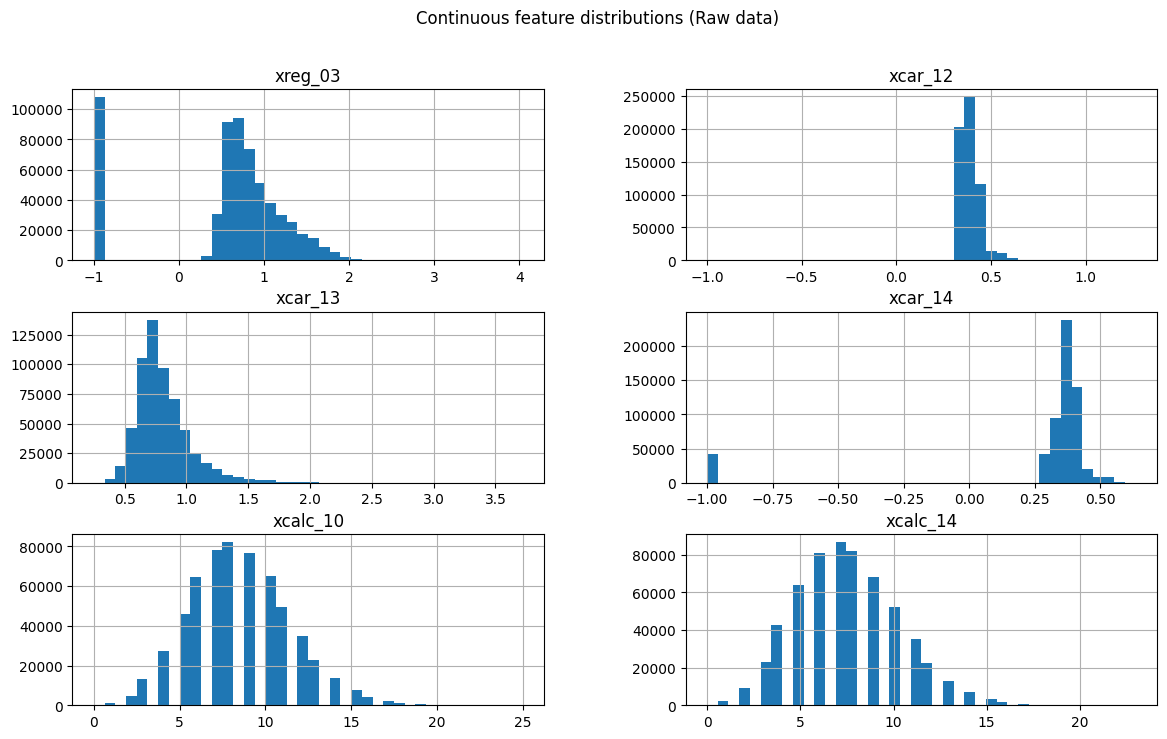

In [20]:
continuous_strong = [
    c for c in continuous_cols
    if df[c].nunique() > 20
]

print("Continuous with high cardinality:", len(continuous_strong))
cols_to_plot = continuous_strong[:6] if len(continuous_strong) > 0 else continuous_cols[:6]

df[cols_to_plot].hist(bins=40, figsize=(14, 8))
plt.suptitle("Continuous feature distributions (Raw data)")
plt.show()

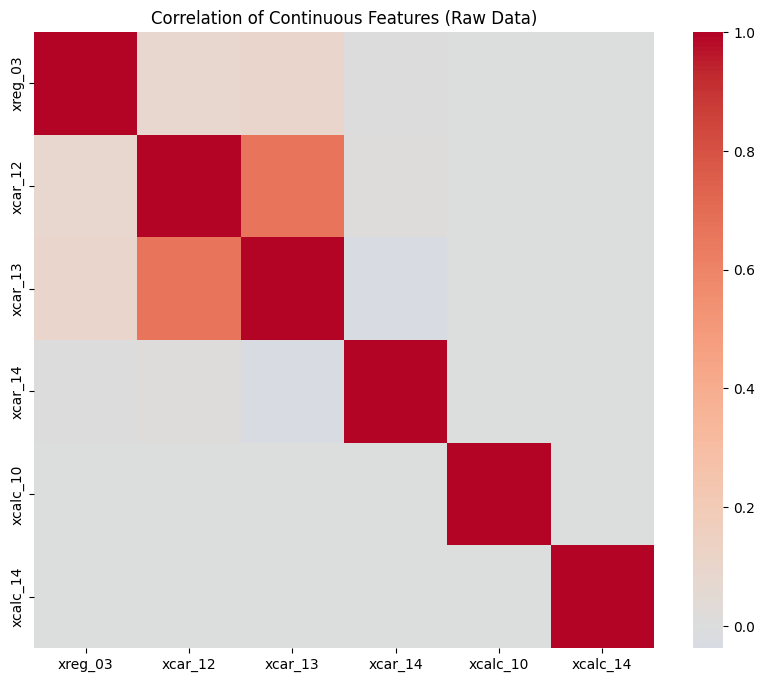

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[continuous_strong].corr(), cmap='coolwarm', center=0)
plt.title("Correlation of Continuous Features (Raw Data)")
plt.show()

In [22]:
def train_logistic_regression(X_train, y_train, X_val, random_state=42, max_iter=2000):

    model = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=max_iter,
        random_state=random_state,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)

    val_proba = model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba >= 0.5).astype(int)

    return model, val_pred, val_proba

In [23]:
log_reg_model, y_val_pred, y_val_proba = train_logistic_regression(X_train, y_train, X_val, random_state=RANDOM_STATE)


Logistic Regression (Raw Data) - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


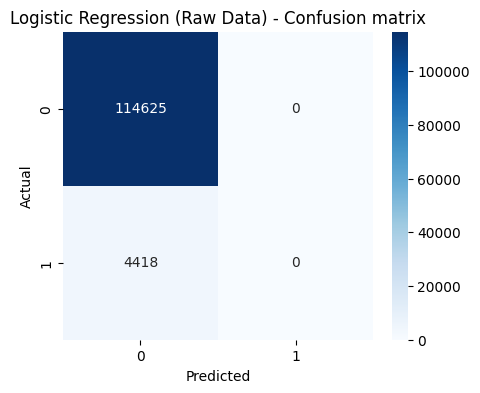

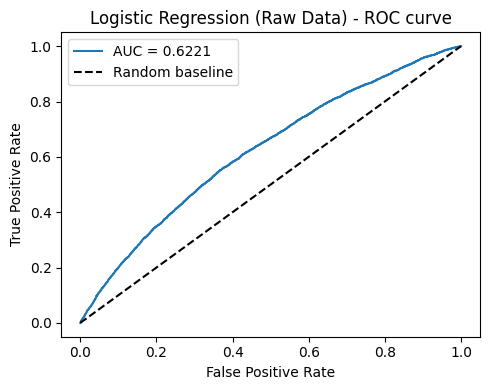

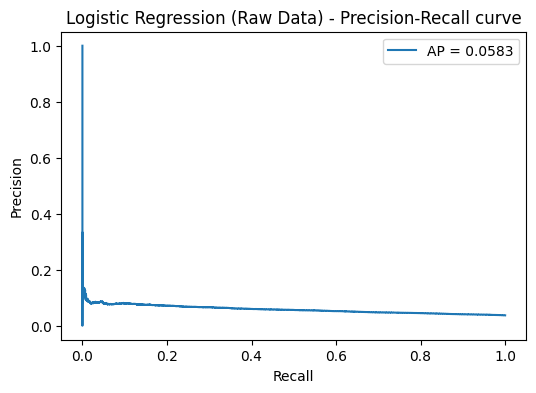

In [24]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred,
    y_proba=y_val_proba,
    model_name="Logistic Regression (Raw Data)", show_pr=True
)

From the **Confusion matrix**:

- The model correctly identifies all majority-class samples.

- It completely fails to detect any minority-class samples.

- Every actual positive case is misclassified as negative.

Despite this, the **ROC curve** still looks better than random. AUC ≈ 0.62 means the model has some ability to rank positive cases higher than negative ones.

**Precision-Recall Curve**:
- Precision drops to nearly 0 immediately.

- Recall also stays near 0.

- Average Precision ≈ 0.058, which is very low.


The minority class is extremely difficult for the model to recognize in its raw state. The PR curve emphasizes how weak the signal is when directly predicting positives.

##### *Overall Conclusion from Baseline Model:*
The baseline Logistic Regression model on raw data:

- Detects 0 positive cases.

- Shows that the dataset is heavily imbalanced, making it impossible for the model to learn without preprocessing.

- Has moderate ROC-AUC (~0.62), indicating potentially usable underlying relationships, but class imbalance prevents the classifier from using them effectively.

### 3. Binning methods 

> Use at least two binning methods (on features of your choice, with your choice of parameters) and comment on their effects on classification performance. I.e., one kind of classifier trained for each binning and a comparison of the effect of binning methods against each other.

The raw logistic regression model completely fails to detect the minority class.

I will try *two different binning strategies* on the same set of continuous variables:

 1) **Equal-width binning**

Each bin has the same numeric width.

2) **Quantile (equal-frequency) binning**

Each bin contains approximately the same number of samples.

I select three continuous / high-cardinality features.

In [25]:
features_to_bin = continuous_strong[:3]

##### Equal-width binning

In [26]:
def apply_equal_width_binning(X, features, n_bins=10):
    X_new = X.copy()
    discretizer = KBinsDiscretizer(
        n_bins=n_bins,
        encode="ordinal",
        strategy="uniform"
    )
    X_new[features] = discretizer.fit_transform(X_new[features])
    return X_new, discretizer

In [27]:
Xtrain_bw, bw_disc = apply_equal_width_binning(X_train, features_to_bin, n_bins=8)
Xval_bw = X_val.copy()
Xval_bw[features_to_bin] = bw_disc.transform(Xval_bw[features_to_bin])


In [28]:
model_bw, y_val_pred_bw, y_val_proba_bw = train_logistic_regression(
    Xtrain_bw, y_train, Xval_bw
)


LogReg - Equal-Width Binning - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


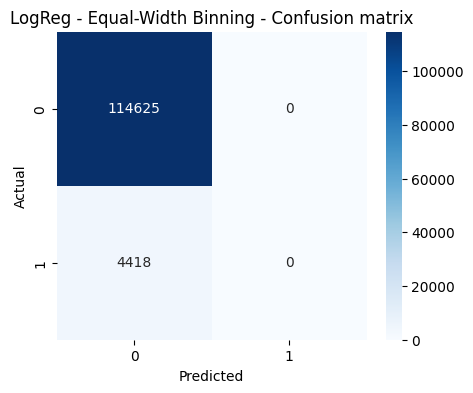

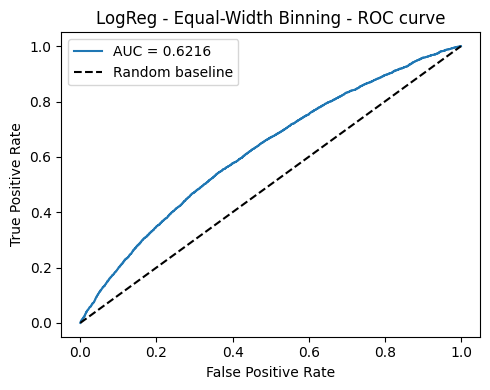

In [29]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_bw,
    y_proba=y_val_proba_bw,
    model_name="LogReg - Equal-Width Binning"
)

We have the same result as before.

##### Quantile (Equal-Frequency) Binning

In [30]:
def apply_quantile_binning(X, features, n_bins=10):
    X_new = X.copy()
    discretizer = KBinsDiscretizer(
        n_bins=n_bins,
        encode="ordinal",
        strategy="quantile"
    )
    X_new[features] = discretizer.fit_transform(X_new[features])
    return X_new, discretizer


In [31]:
Xtrain_bq, bq_disc = apply_quantile_binning(X_train, features_to_bin, n_bins=8)
Xval_bq = X_val.copy()
Xval_bq[features_to_bin] = bq_disc.transform(Xval_bq[features_to_bin])


/home/daria/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/daria/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/daria/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [32]:
model_bq, y_val_pred_bq, y_val_proba_bq = train_logistic_regression(
    Xtrain_bq, y_train, Xval_bq
)


LogReg - Quantile Binning - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


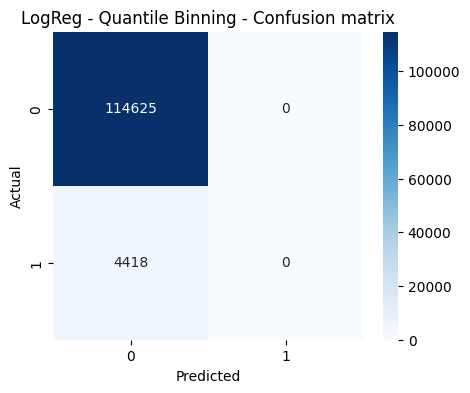

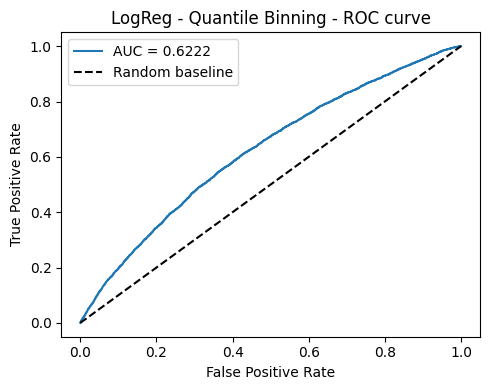

In [33]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_bq,
    y_proba=y_val_proba_bq,
    model_name="LogReg - Quantile Binning"
)

After applying both binning methods, the classifier still predicts only the majority class, which leads to undefined precision/recall for class 1. 

This confirms that binning alone does not address the class imbalance, and motivates the need for balancing techniques.

### 4. Balancing techniques

> Use at least two data balancing techniques on the correct part of the dataset and comment on its effects on classification performance. Focus on the comparison of methods between each other. I.e., one type of classifier trained for each balancing and a comparison of the effect of balancing methods against each other. 

Because the dataset is extremely imbalanced, the baseline logistic regression model completely ignored the minority class. The F1 score for the positive class was 0, meaning it predicted zero positives.
To address this, I tested four different balancing strategies:

1) *Random UnderSampling (RUS)*

2) *Random OverSampling (ROS)*

3) *SMOTE*

4) *ADASYN*

##### Random Under-Sampling (RUS)

RUS reduces majority class size.

In [34]:
def balance_with_under_sampling(X, y, random_state=42):
    rus = RandomUnderSampler(random_state=random_state)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res, rus

In [35]:
Xtrain_rus, ytrain_rus, rus_obj = balance_with_under_sampling(X_train, y_train)

print("After RUS:", Xtrain_rus.shape, ytrain_rus.value_counts())

After RUS: (25876, 57) y
0    12938
1    12938
Name: count, dtype: int64


In [36]:
model_rus, y_val_pred_rus, y_val_proba_rus = train_logistic_regression(Xtrain_rus, ytrain_rus, X_val)


LogReg - Random Undersampling - classification report
              precision    recall  f1-score   support

           0     0.9733    0.6328    0.7670    114625
           1     0.0546    0.5498    0.0993      4418

    accuracy                         0.6297    119043
   macro avg     0.5139    0.5913    0.4331    119043
weighted avg     0.9392    0.6297    0.7422    119043


F1 scores 
F1 (positive class = 1): 0.0993
F1 (macro):             0.4331
F1 (weighted):          0.7422


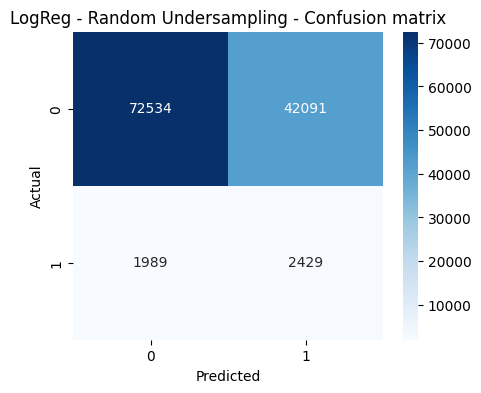

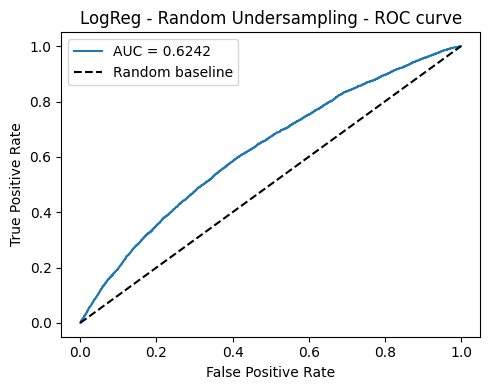

In [37]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_rus,
    y_proba=y_val_proba_rus,
    model_name="LogReg - Random Undersampling"
)

##### Random Over-Sampling(ROS)

ROS increases minority class size using duplication.

In [26]:
def balance_with_ros(X, y, random_state=42):
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)
    return X_res, y_res, ros

In [27]:
Xtrain_ros, ytrain_ros, ros_obj = balance_with_ros(X_train, y_train)
print("After ROS:", Xtrain_ros.shape, ytrain_ros.value_counts())

After ROS: (688376, 57) y
0    344188
1    344188
Name: count, dtype: int64


In [28]:
model_ros, y_val_pred_ros, y_val_proba_ros = train_logistic_regression(Xtrain_ros, ytrain_ros, X_val)


LogReg - Random Oversampling - classification report
              precision    recall  f1-score   support

           0     0.9734    0.6339    0.7678    114625
           1     0.0548    0.5502    0.0996      4418

    accuracy                         0.6308    119043
   macro avg     0.5141    0.5921    0.4337    119043
weighted avg     0.9393    0.6308    0.7430    119043


F1 scores 
F1 (positive class = 1): 0.0996
F1 (macro):             0.4337
F1 (weighted):          0.7430


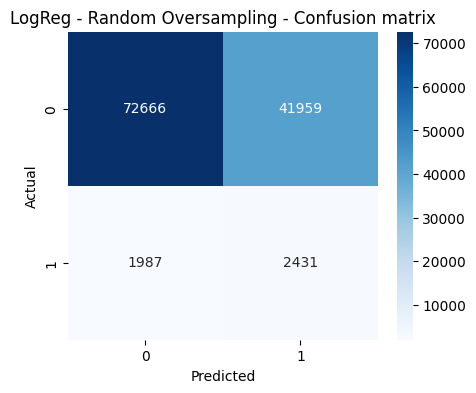

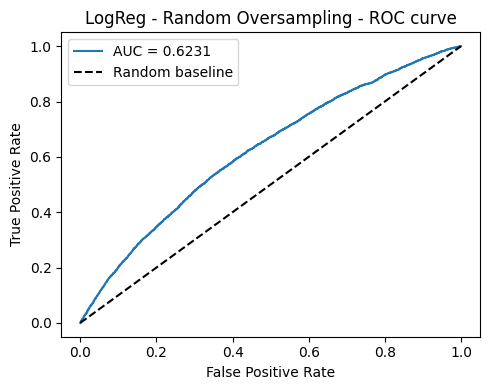

In [41]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_ros,
    y_proba=y_val_proba_ros,
    model_name="LogReg - Random Oversampling"
)

##### SMOTE

In [43]:
def balance_with_smote(X, y, random_state=42):
    smote = SMOTE(random_state=random_state, k_neighbors=5)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res, smote

In [44]:
Xtrain_smote, ytrain_smote, smote_obj = balance_with_smote(X_train, y_train)

print("After SMOTE:", Xtrain_smote.shape, ytrain_smote.value_counts())

After SMOTE: (688376, 57) y
0    344188
1    344188
Name: count, dtype: int64


In [45]:
model_smote, y_val_pred_smote, y_val_proba_smote = train_logistic_regression(Xtrain_smote, ytrain_smote, X_val)

/home/daria/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg - SMOTE - classification report
              precision    recall  f1-score   support

           0     0.9635    0.9260    0.9444    114625
           1     0.0448    0.0901    0.0599      4418

    accuracy                         0.8950    119043
   macro avg     0.5042    0.5081    0.5021    119043
weighted avg     0.9294    0.8950    0.9116    119043


F1 scores 
F1 (positive class = 1): 0.0599
F1 (macro):             0.5021
F1 (weighted):          0.9116


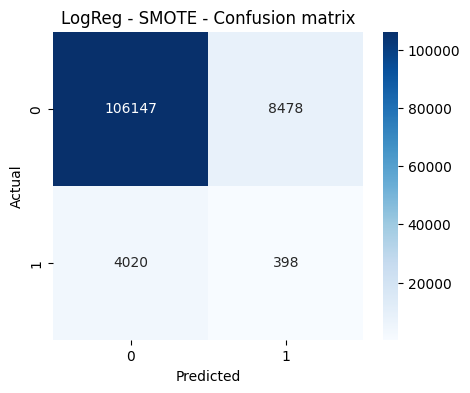

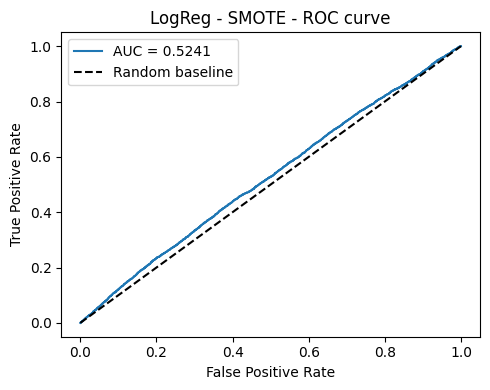

In [46]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_smote,
    y_proba=y_val_proba_smote,
    model_name="LogReg - SMOTE"
)

##### ADASYN

In [47]:
def balance_with_adasyn(X, y, random_state=42):
    ada = ADASYN(random_state=random_state)
    X_res, y_res = ada.fit_resample(X, y)
    return X_res, y_res, ada

In [48]:
Xtrain_ada, ytrain_ada, ada_obj = balance_with_adasyn(X_train, y_train)

print("After ADASYN:", Xtrain_ada.shape, ytrain_ada.value_counts())

After ADASYN: (691149, 57) y
1    346961
0    344188
Name: count, dtype: int64


In [49]:
model_ada, y_val_pred_ada, y_val_proba_ada = train_logistic_regression(Xtrain_ada, ytrain_ada, X_val)


LogReg - ADASYN - classification report
              precision    recall  f1-score   support

           0     0.9634    0.9254    0.9440    114625
           1     0.0440    0.0892    0.0590      4418

    accuracy                         0.8943    119043
   macro avg     0.5037    0.5073    0.5015    119043
weighted avg     0.9293    0.8943    0.9112    119043


F1 scores 
F1 (positive class = 1): 0.0590
F1 (macro):             0.5015
F1 (weighted):          0.9112


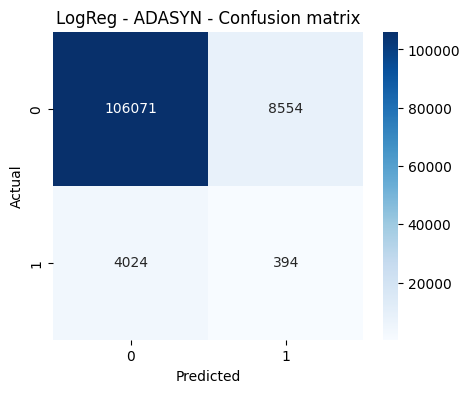

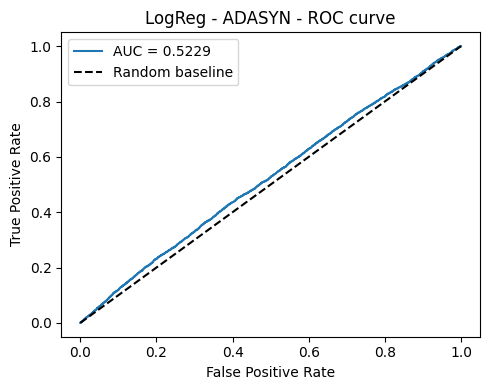

In [50]:
evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_ada,
    y_proba=y_val_proba_ada,
    model_name="LogReg - ADASYN"
)

**RUS** and **ROS** give the best F1 scores, they drastically increase recall but at the cost of precision.

None of the balancing methods fully solve the problem.

We will likely see much bigger improvements after feature engineering, transformations, or using PCA, because logistic regression benefits strongly from better feature structure.

### 5. Features transformation

> Transform the features appropriately and prepare new ones (i.e., feature engineering) - focus on the increase in the model's performance (possibly in combination with further steps).

Define feature groups:

In [29]:
all_feature_cols = [c for c in df.columns if c != "y"]
cont_cols = [c for c in all_feature_cols if (c not in bin_cols) and (c not in cat_cols)]

Missing values are handled before any other transformation:

- continuous features → median

- categorical and binary features → most frequent value

In [30]:
def impute_fit_transform(Xtr, Xva, cont_cols, cat_cols, bin_cols):
    Xtr2 = Xtr.copy()
    Xva2 = Xva.copy()

    imp_cont = SimpleImputer(strategy="median")
    imp_cat = SimpleImputer(strategy="most_frequent")
    imp_bin = SimpleImputer(strategy="most_frequent")

    Xtr2[cont_cols] = imp_cont.fit_transform(Xtr2[cont_cols])
    Xva2[cont_cols] = imp_cont.transform(Xva2[cont_cols])

    if len(cat_cols) > 0:
        Xtr2[cat_cols] = imp_cat.fit_transform(Xtr2[cat_cols])
        Xva2[cat_cols] = imp_cat.transform(Xva2[cat_cols])

    if len(bin_cols) > 0:
        Xtr2[bin_cols] = imp_bin.fit_transform(Xtr2[bin_cols])
        Xva2[bin_cols] = imp_bin.transform(Xva2[bin_cols])

    return Xtr2, Xva2


Write function for every transformation, start with Logarithmic transformation. 



##### *Log-transform continuous features*

Log transformation reduces continuous features skewness.

In [31]:
def safe_log1p_transform(Xtr, Xva, cols):
    Xtr_l = Xtr[cols].copy()
    Xva_l = Xva[cols].copy()

    for c in cols:
        mn = Xtr_l[c].min()
        shift = 0.0
        if mn <= -1:
            shift = -mn + 1.0
        Xtr_l[c] = np.log1p(Xtr_l[c] + shift)
        Xva_l[c] = np.log1p(Xva_l[c] + shift)

    return Xtr_l, Xva_l


##### *Scaling Continuous Features*

Logistic Regression is sensitive to feature scale, and scaling helps faster convergence and more stable coefficients.

 Scale only continuous-like features.

In [32]:
def scale_fit_transform(Xtr, Xva, cols):
    scaler = StandardScaler()

    Xtr_s = pd.DataFrame(
        scaler.fit_transform(Xtr[cols]),
        columns=cols,
        index=Xtr.index
    )

    Xva_s = pd.DataFrame(
        scaler.transform(Xva[cols]),
        columns=cols,
        index=Xva.index
    )

    return Xtr_s, Xva_s

##### *One-Hot Encode categorical features*

In [33]:
def one_hot_fit_transform(Xtr, Xva, cat_cols):
    Xtr_in = Xtr[cat_cols].astype(str)
    Xva_in = Xva[cat_cols].astype(str)

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    Xtr_ohe = ohe.fit_transform(Xtr_in)
    Xva_ohe = ohe.transform(Xva_in)

    names = ohe.get_feature_names_out(cat_cols)

    Xtr_df = pd.DataFrame(Xtr_ohe, columns=names, index=Xtr.index)
    Xva_df = pd.DataFrame(Xva_ohe, columns=names, index=Xva.index)

    return Xtr_df, Xva_df


In [34]:
def build_design_matrix(
    Xtr_base,
    Xva_base,
    use_log=False,
    use_scaling=False,
    use_ohe=False,
    log_cols=None
):
    Xtr_imp, Xva_imp = impute_fit_transform(
        Xtr_base, Xva_base, cont_cols, cat_cols, bin_cols
    )

    Xtr_cont = Xtr_imp[cont_cols].astype(float)
    Xva_cont = Xva_imp[cont_cols].astype(float)

    if use_log:
        if log_cols is None:
            log_cols = cont_cols[:5]
        Xtr_log, Xva_log = safe_log1p_transform(Xtr_cont, Xva_cont, log_cols)
        Xtr_cont[log_cols] = Xtr_log
        Xva_cont[log_cols] = Xva_log

    if use_scaling:
        Xtr_cont, Xva_cont = scale_fit_transform(Xtr_cont, Xva_cont, cont_cols)

    Xtr_bin = Xtr_imp[bin_cols].astype(int)
    Xva_bin = Xva_imp[bin_cols].astype(int)

    if use_ohe and len(cat_cols) > 0:
        Xtr_cat, Xva_cat = one_hot_fit_transform(Xtr_imp, Xva_imp, cat_cols)
    else:
        Xtr_cat = Xtr_imp[cat_cols].astype(float) if len(cat_cols) > 0 else pd.DataFrame(index=Xtr_imp.index)
        Xva_cat = Xva_imp[cat_cols].astype(float) if len(cat_cols) > 0 else pd.DataFrame(index=Xva_imp.index)

    Xtr_final = pd.concat([Xtr_cont, Xtr_cat, Xtr_bin], axis=1)
    Xva_final = pd.concat([Xva_cont, Xva_cat, Xva_bin], axis=1)

    return Xtr_final, Xva_final


Transformed Features - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


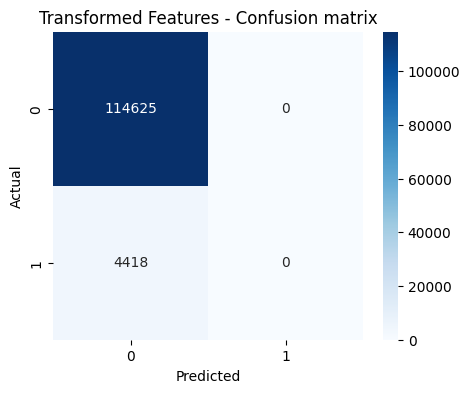

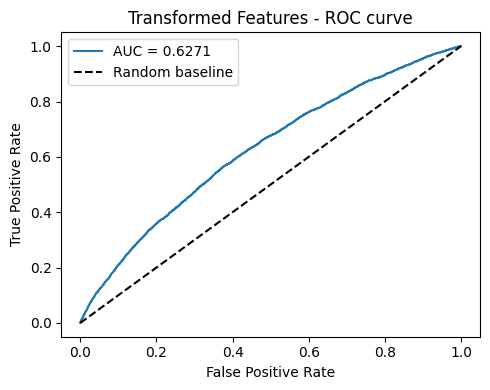

In [35]:
Xtr_final, Xva_final = build_design_matrix(
    X_train,
    X_val,
    use_log=True,
    use_scaling=True,
    use_ohe=True
)

model, y_val_pred, y_val_proba = train_logistic_regression(
    Xtr_final,
    y_train,
    Xva_final,
    random_state=RANDOM_STATE
)

evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred,
    y_proba=y_val_proba,
    model_name="Transformed Features"
)

Despite applying log-transformations, scaling, and one-hot encoding, the confusion matrix shows that the classifier predicts only the majority class at the default decision threshold.

This behavior is expected for highly imbalanced datasets. The ROC-AUC score indicates that the model does learn a meaningful ranking of observations, but without balancing or threshold adjustment, the predicted probabilities never exceed the default threshold for class 1. Feature transformations alone are insufficient to achieve non-zero recall for the minority class.

### 6. Feature selection

> Try to find some suitable subset of features - use at least two feature selection methods. Evaluate your choice on the validation set and discuss the influence. Do not use PCA (principal component analysis) in this step. Manual selection will not be accepted.

In this step i applied two methods:
- *SelectKBest* - Filter method based on univariate statistical dependence
- *Recursive Feature Elimination*

##### SelectKBest

In [36]:
fs_results = []

def run_fs_experiment(tag, Xtr_fs, Xva_fs):
    model, pred, proba = train_logistic_regression(
        Xtr_fs, y_train, Xva_fs, random_state=RANDOM_STATE
    )
    f1p = f1_score(y_val, pred, pos_label=1)
    fs_results.append({"method": tag, "f1_pos": f1p, "n_features": Xtr_fs.shape[1]})
    evaluate_model(y_val, pred, proba, model_name=tag)


SelectKBest (k=100) - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


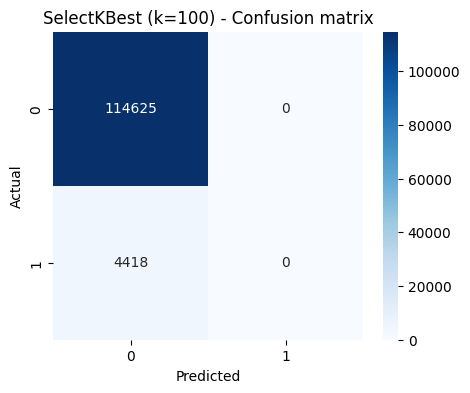

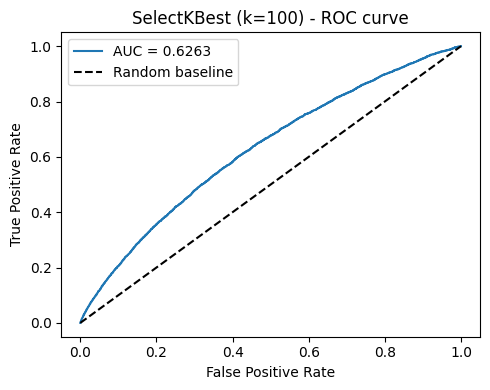

In [50]:
k_best = 100

skb = SelectKBest(score_func=f_classif, k=k_best)

Xtr_skb = skb.fit_transform(Xtr_final, y_train)
Xva_skb = skb.transform(Xva_final)

cols_skb = Xtr_final.columns[skb.get_support()]

Xtr_skb = pd.DataFrame(
    Xtr_skb,
    columns=cols_skb,
    index=Xtr_final.index
)

Xva_skb = pd.DataFrame(
    Xva_skb,
    columns=cols_skb,
    index=Xva_final.index
)

run_fs_experiment(f"SelectKBest (k={k_best})", Xtr_skb, Xva_skb)

##### Recursive Feature Elimination


RFE (LogReg) - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


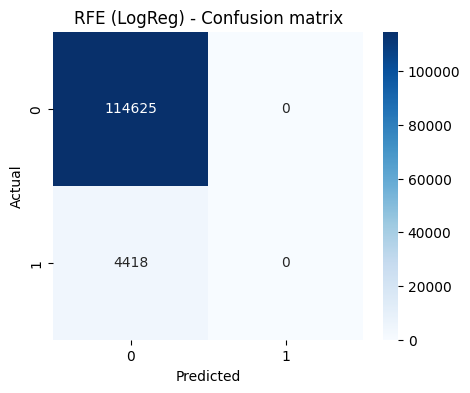

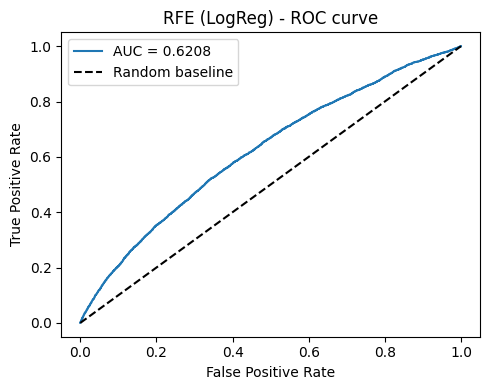

In [51]:
rfe = RFE(
    estimator=LogisticRegression(
        solver="liblinear",
        max_iter=800,
        random_state=RANDOM_STATE
    ),
    n_features_to_select=80,
    step=0.3
)

rfe.fit(Xtr_final, y_train)

cols_rfe = Xtr_final.columns[rfe.get_support()]

Xtr_rfe = pd.DataFrame(
    rfe.transform(Xtr_final),
    columns=cols_rfe,
    index=Xtr_final.index
)

Xva_rfe = pd.DataFrame(
    rfe.transform(Xva_final),
    columns=cols_rfe,
    index=Xva_final.index
)

run_fs_experiment("RFE (LogReg)", Xtr_rfe, Xva_rfe)

Although dimensionality was reduced substantially, classification performance on the minority class remained unchanged.

This indicates that feature selection alone is insufficient to address the strong class imbalance in the dataset.
The decision boundary learned by Logistic Regression remains dominated by the majority class, regardless of the selected feature subset.

### 7. PCA

PCA must be applied only after scaling, otherwise components are dominated by large-scale features.
Therefore, we use the already transformed feature matrix from Step 5.

We evaluate multiple PCA configurations to understand how the number of components influences model performance.

Transformed features without scaling:

In [53]:
Xtr_t, Xva_t = build_design_matrix(
    X_train,
    X_val,
    use_log=True,
    use_scaling=False,
    use_ohe=True
)

Xtr_ros, ytr_ros, _ = balance_with_ros(Xtr_t, y_train, random_state=RANDOM_STATE)

pca_results_no_scale = []

def run_pca_no_scale(n_comp):
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)

    Xtr_pca = pca.fit_transform(Xtr_ros)
    Xva_pca = pca.transform(Xva_t)

    model, pred, proba = train_logistic_regression(
        pd.DataFrame(Xtr_pca, index=Xtr_ros.index),
        ytr_ros,
        pd.DataFrame(Xva_pca, index=Xva_t.index),
        random_state=RANDOM_STATE
    )

    f1p = f1_score(y_val, pred, pos_label=1)
    pca_results_no_scale.append({"n_components": n_comp, "f1_pos": f1p})

    return pred, proba

for k in [10, 25, 50, 100]:
    run_pca_no_scale(k)

pca_no_scale_df = pd.DataFrame(pca_results_no_scale)
display(pca_no_scale_df)

,n_components,f1_pos
0,10,0.068350
1,25,0.095227
2,50,0.098645
3,100,0.099856


Transformed features with scaling:

In [37]:
Xtr_ts, Xva_ts = build_design_matrix(
    X_train,
    X_val,
    use_log=True,
    use_scaling=True,
    use_ohe=True
)

Xtr_ros_s, ytr_ros_s, _ = balance_with_ros(Xtr_ts, y_train, random_state=RANDOM_STATE)

pca_results_scaled = []

def run_pca_scaled(n_comp):
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)

    Xtr_pca = pca.fit_transform(Xtr_ros_s)
    Xva_pca = pca.transform(Xva_ts)

    model, pred, proba = train_logistic_regression(
        pd.DataFrame(Xtr_pca, index=Xtr_ros_s.index),
        ytr_ros_s,
        pd.DataFrame(Xva_pca, index=Xva_ts.index),
        random_state=RANDOM_STATE
    )

    f1p = f1_score(y_val, pred, pos_label=1)
    pca_results_scaled.append({"n_components": n_comp, "f1_pos": f1p})

    return pred, proba

for k in [50, 100]:
    run_pca_scaled(k)

pca_scaled_df = pd.DataFrame(pca_results_scaled)
display(pca_scaled_df)

,n_components,f1_pos
0,50,0.098822
1,100,0.099662


Show the result with the best number of components: 


PCA (100 components, transformed features) - classification report
              precision    recall  f1-score   support

           0     0.9736    0.6292    0.7644    114625
           1     0.0548    0.5582    0.0999      4418

    accuracy                         0.6265    119043
   macro avg     0.5142    0.5937    0.4321    119043
weighted avg     0.9395    0.6265    0.7397    119043


F1 scores 
F1 (positive class = 1): 0.0999
F1 (macro):             0.4321
F1 (weighted):          0.7397


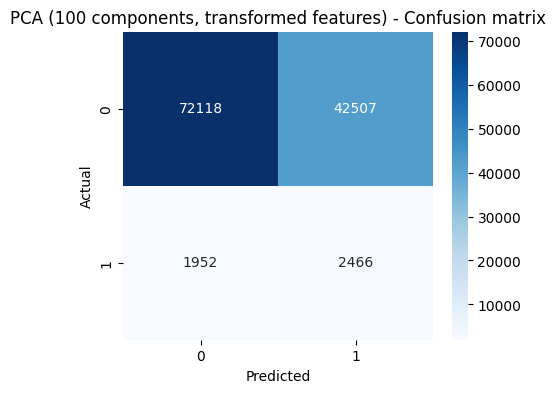

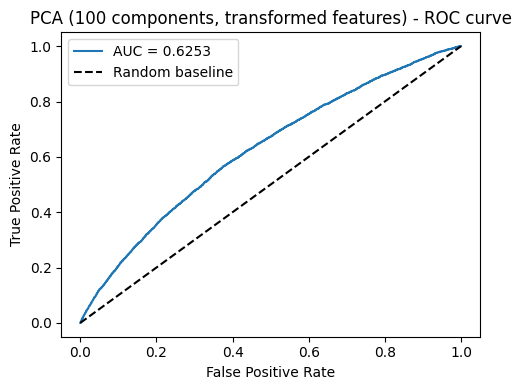

In [38]:
Xtr_t, Xva_t = build_design_matrix(
    X_train,
    X_val,
    use_log=True,
    use_scaling=False,
    use_ohe=True
)

Xtr_ros, ytr_ros, _ = balance_with_ros(
    Xtr_t, y_train, random_state=RANDOM_STATE
)

pca_best = PCA(n_components=100, random_state=RANDOM_STATE)

Xtr_pca = pca_best.fit_transform(Xtr_ros)
Xva_pca = pca_best.transform(Xva_t)

Xtr_pca = pd.DataFrame(Xtr_pca, index=Xtr_ros.index)
Xva_pca = pd.DataFrame(Xva_pca, index=Xva_t.index)

model_pca, y_val_pred_pca, y_val_proba_pca = train_logistic_regression(
    Xtr_pca,
    ytr_ros,
    Xva_pca,
    random_state=RANDOM_STATE
)

evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_pca,
    y_proba=y_val_proba_pca,
    model_name="PCA (100 components, transformed features)"
)

The results show that increasing the number of components improves the F1-score
for the positive class, but the improvement saturates around 50–100 components.
Applying PCA after standardization did not provide a significant advantage
over PCA on unscaled transformed features.

### 8. Final model comparison

> Try to find the best combination of the previous steps and run final classification tests on the correct part of the dataset - first for the original data, second for the best-found combination of the previous preprocessing steps. Compare the results and discuss.

Original (raw) data:


Logistic Regression (Raw Data) - classification report
              precision    recall  f1-score   support

           0     0.9629    1.0000    0.9811    114625
           1     0.0000    0.0000    0.0000      4418

    accuracy                         0.9629    119043
   macro avg     0.4814    0.5000    0.4905    119043
weighted avg     0.9272    0.9629    0.9447    119043


F1 scores 
F1 (positive class = 1): 0.0000
F1 (macro):             0.4905
F1 (weighted):          0.9447


/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daria/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


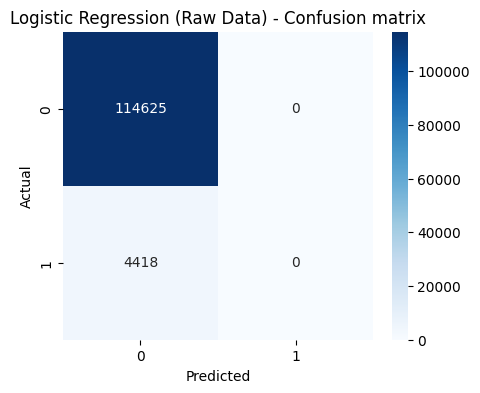

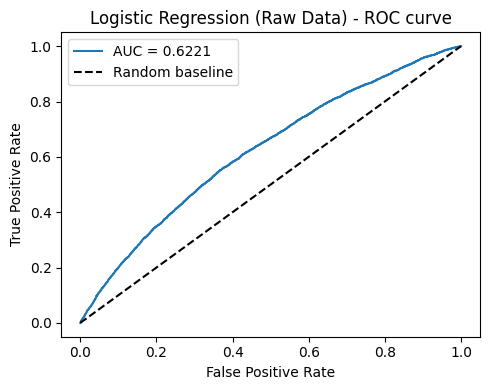

In [54]:
Xtr_raw = X_train.copy()
Xva_raw = X_val.copy()

model_raw, y_val_pred_raw, y_val_proba_raw = train_logistic_regression(
    Xtr_raw,
    y_train,
    Xva_raw,
    random_state=RANDOM_STATE
)

evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_raw,
    y_proba=y_val_proba_raw,
    model_name="Logistic Regression (Raw Data)"
)

From all previous steps, the best-performing setup is:

- log transform

- scaling

- one-hot encoding

- ROS balancing

- PCA(100 components)


Best Preprocessing Combination - classification report
              precision    recall  f1-score   support

           0     0.9736    0.6292    0.7644    114625
           1     0.0547    0.5570    0.0997      4418

    accuracy                         0.6265    119043
   macro avg     0.5142    0.5931    0.4320    119043
weighted avg     0.9395    0.6265    0.7397    119043


F1 scores 
F1 (positive class = 1): 0.0997
F1 (macro):             0.4320
F1 (weighted):          0.7397


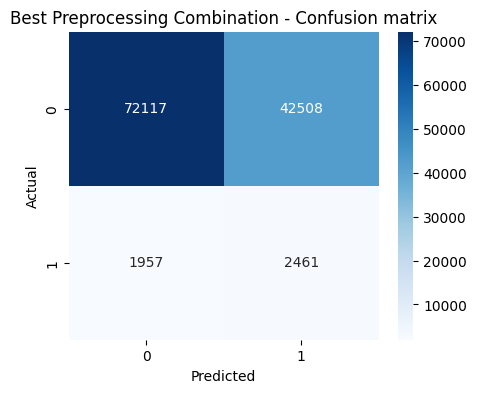

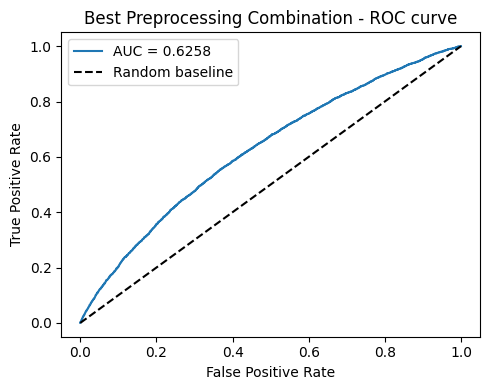

In [45]:
Xtr_trans, Xva_trans = build_design_matrix(
    X_train,
    X_val,
    use_log=True,
    use_scaling=True,
    use_ohe=True
)

Xtr_ros, ytr_ros, _ = balance_with_ros(
    Xtr_trans,
    y_train,
    random_state=RANDOM_STATE
)

pca_final = PCA(n_components=100, random_state=RANDOM_STATE)

Xtr_pca = pca_final.fit_transform(Xtr_ros)
Xva_pca = pca_final.transform(Xva_trans)

Xtr_pca = pd.DataFrame(Xtr_pca, index=Xtr_ros.index)
Xva_pca = pd.DataFrame(Xva_pca, index=Xva_trans.index)

model_final, y_val_pred_final, y_val_proba_final = train_logistic_regression(
    Xtr_pca,
    ytr_ros,
    Xva_pca,
    random_state=RANDOM_STATE
)

evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_final,
    y_proba=y_val_proba_final,
    model_name="Best Preprocessing Combination"
)

The baseline model trained on raw data fails completely to identify
the minority class, resulting in an **F1-score of zero**.

The final model, which combines feature transformations, random oversampling,
and dimensionality reduction using PCA, improves performance(**F1-score = 0.099**).

Nevertheless, the overall performance remains limited. This is primarily due to the
strong class imbalance in the dataset, where the number of non-claim cases significantly
outnumbers claim cases. In such settings, improving recall for the minority class often
comes at the cost of a large number of false positives, which can be observed in the
confusion matrix.

**The End**